In [401]:

import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
from IPython.display import display_html
from networkx.algorithms import community
from collections import defaultdict
import seaborn as sns




## 1. Introduction: Global nematode–mammal interactions (2018)


The nematode–mammal interaction network represents global relationships between parasitic nematodes and their mammalian hosts. The dataset, sourced from the helminthR package (2018), includes species-level information for both groups. Each node represents a nematode or a mammal species, and each edge shows a recorded interaction between them.

Analyzing this network helps reveal patterns of host–parasite connections, such as which mammals host the most parasites and which nematodes infect multiple species. Through network analysis techniques like centrality, modularity, and core analysis, we can identify key species, examine the structure of host–parasite communities, and gain insight into the ecological and biological processes that shape these global interactions.

## 2. Data Preparation 


The dataset was loaded from two CSV files: one containing the edges that represent interactions between nematodes and mammal species, and another with node metadata that describes each species. The metadata file was cleaned by removing extra spaces and symbols from column names to ensure consistent formatting. A new column named organism was created to classify each node as either a host or a parasite based on the is_host flag. This structured data provides the foundation for building and analyzing the nematode–mammal interaction network.

In [371]:
mamal_df = pd.read_csv(filepath_or_buffer="mammal_nematode/edges.csv")
metadata = pd.read_csv("mammal_nematode/nodes.csv")
metadata.columns = metadata.columns.str.strip().str.replace('#', '').str.replace(' ', '_')


In [372]:
animal_map = {1:"host",0:"parasite"}
metadata["organism"] =  metadata["is_host"].map(animal_map)

In [373]:
metadata.head()

,_index,name,full_name,locality,group,is_host,_pos,organism
0,0,Squalus blainville,"Proleptus robustus (van Beneden, 1871)",Northeast Atlantic,Nematoda,1,"array([32.67422356, 46.0460785 ])",host
1,1,Acanthocephaloides incrassatus,NaN,NaN,Teleostei,0,"array([39.44431659, 25.20409242])",parasite
2,2,Gobius bucchichi,Deretrema (Spinoderetrema) scorpaenicola Barto...,Western Mediterranean,Trematoda,1,"array([43.9399518 , 28.96108572])",host
3,3,Acanthocephaloides propinquus,NaN,NaN,Teleostei,0,"array([37.69593368, 27.68332545])",parasite
4,4,Gobius cruentatus,"Acanthocephaloides propinquus (Dujardin, 1845)",Atlantic Ocean,Acanthocephala,1,"array([30.49701772, 30.25827091])",host


In [374]:
host_nodes = metadata[metadata["organism"] == "host"]["_index"].to_list()
parasite_nodes = metadata[metadata["organism"] != "host"]["_index"].to_list()
GN = nx.Graph()
GN.add_nodes_from(host_nodes,bipartite = 1)
GN.add_nodes_from(parasite_nodes,bipartite = 0)
GN.add_edges_from(list(mamal_df.itertuples(index=False, name=None)))

In [375]:
bipartite.is_bipartite(GN)

True

In [376]:
node_colors = {}
for node,data in GN.nodes(data=True):
    data["name"] = (metadata[metadata["_index"] == node]).iloc[0]["name"]
    organism = (metadata[metadata["_index"] == node]).iloc[0]["organism"]
    data["organism"] = organism
    node_colors[node]= "tomato" if organism == "host" else "skyblue"
    # print(node,data)


In [434]:
#helper function
def display_side_by_side(dfs, titles=None):
    html_str = "<div style='display:flex;flex-flow:row nowrap;column-gap:20px'>"
    for df, title in zip(dfs, titles):
        html_str += f"""
        <div style="margin:10px">
            <h4 style="text-align:center">{title}</h4>
            {df.to_html()}
        </div>"""
    html_str += "</div>"

    display_html(html_str, raw=True)

def top_n_degrees(degree_dict: dict, n: int) -> pd.DataFrame:
    df = pd.DataFrame(list(degree_dict.items()), columns=["Node", "Degree"])
    df["Degree_(%)"] = (df["Degree"] / df["Degree"].sum()) * 100


    df = df.sort_values(by="Degree", ascending=False).head(n).reset_index(drop=True)
    return df.reset_index(drop=True)



def get_island_graph_components(G, threshold=3, remove_unconnected=False):
    strong_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d["weight"] >= threshold]
    island_graph = nx.Graph()
    island_graph.add_edges_from(strong_edges)

    if remove_unconnected:
        island_graph.remove_nodes_from(list(nx.isolates(island_graph)))

    components = [island_graph.subgraph(c).copy() for c in nx.connected_components(island_graph)]
    components.sort(key=lambda x: x.number_of_nodes(), reverse=True)

    return island_graph, components


def plot_island_graph(G,threshold, node_size=400):
    if G.number_of_edges() == 0:
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, "No edges to plot", ha="center", va="center")
        ax.axis("off")
        return fig

    pos = nx.kamada_kawai_layout(G)
    weights = [d["weight"] for _, _, d in G.edges(data=True)]
    widths = [w / max(weights) * 4 for w in weights] if weights else 1

    fig, ax = plt.subplots(figsize=(15, 10))
    nx.draw(
        G,
        pos,
        node_color="skyblue",
        edge_color="gray",
        width=widths,
        node_size=node_size,
        with_labels=True,
        font_size=8,
        ax=ax
    )
    ax.axis("off")
    ax.set_title(f"Island Graph (edges weight ≥ {threshold})")
    


def analyze_island_metrics(G, top_n=10, graph_label="Island Graph"):
    # Compute clustering and density metrics
    avg_clustering = nx.average_clustering(G)
    avg_weighted_clustering = nx.average_clustering(G, weight="weight")
    density = nx.density(G)

    # Summary dataframe
    clustering_df = pd.DataFrame(
        [
            ["Average Clustering", avg_clustering],
            ["Weighted Average Clustering", avg_weighted_clustering],
            ["Density", density]
        ],
        columns=["Metric Name", "Result"]
    )

    # Compute centrality measures
    deg_centrality = nx.degree_centrality(G)
    bet_centrality = nx.betweenness_centrality(G)
    eig_centrality = nx.eigenvector_centrality(G)

    # Create top-n tables
    top_degree_df = top_n_degrees(deg_centrality, top_n)
    top_betweenness_df = top_n_degrees(bet_centrality, top_n)
    top_eigen_df = top_n_degrees(eig_centrality, top_n)

    # Display formatted tables
    display_side_by_side(
        [
            clustering_df.style.hide(axis="index"),
            top_degree_df,
            top_betweenness_df,
            top_eigen_df
        ],
        [f"{graph_label} Metrics", "Degree Centrality", "Betweenness Centrality", "Eigenvector Centrality"]
    )

    # Return all relevant data
    return {
        "graph": G,
        "clustering": clustering_df,
        "degree_centrality": top_degree_df,
        "betweenness_centrality": top_betweenness_df,
        "eigenvector_centrality": top_eigen_df
    }

    


def analyze_connectivity(G, graph_label="Graph"):
    articulation_points = list(nx.articulation_points(G))
    bridges = list(nx.bridges(G))

    summary = pd.DataFrame({
        "Metric": ["Articulation Points", "Bridges"],
        "Count": [len(articulation_points), len(bridges)],
        "Details": [
            articulation_points if articulation_points else "None",
            bridges if bridges else "None"
        ]
    })

    summary.index = [f"{graph_label} - {m}" for m in summary["Metric"]]
    # summary.drop(columns=["Metric"], inplace=True)

    return summary.style.hide(axis="index")



def summarize_core_numbers(G, top_n=None):
    core_numbers = nx.core_number(G)
    core_groups = defaultdict(list)

    for node, core_val in core_numbers.items():
        core_groups[core_val].append(node)

    # Sort by core number descending (deepest core first)
    core_items = sorted(core_groups.items(), reverse=True)

    if top_n is not None:
        core_items = core_items[:top_n]

    df = pd.DataFrame([
        {"Core_Number": k, "Node_Count": len(v), "Nodes": sorted(v)}
        for k, v in core_items
    ])

    return df

def summarize_component_counts(componentList, top_n=None):

    nodes =  []
    for comp in componentList:
        nodes.append(
            {
                "Component Count": len(comp),
                "Details": list(comp.nodes())
            }
            
            )

    df = pd.DataFrame(nodes).sort_values(by="Component Count",ascending=False).head(top_n)

    return df.style.hide(axis="index")



def plot_island_evolution(graph, weight_attr='weight', title='Island evolution across thresholds'):
    weights = [d.get(weight_attr, 0) for _, _, d in graph.edges(data=True)]
    if not weights:
        raise ValueError("Graph has no edges with the specified weight attribute.")
    
    min_w, max_w = int(min(weights)), int(max(weights))
    thresholds = range(min_w, max_w + 1)
    edges_count, comps_count, largest_size = [], [], []

    for t in thresholds:
        sub_edges = [(u, v) for u, v, d in graph.edges(data=True) if d.get(weight_attr, 0) >= t]
        subG = graph.edge_subgraph(sub_edges).copy()
        edges_count.append(subG.number_of_edges())
        comps = list(nx.connected_components(subG))
        comps_count.append(len(comps))
        largest_size.append(max((len(c) for c in comps), default=0))

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, edges_count, label="Edges remaining")
    plt.plot(thresholds, comps_count, label="Number of islands")
    plt.plot(thresholds, largest_size, label="Largest island size")
    plt.xlabel("Threshold (minimum edge weight)")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.show()





def plot_island_density_row(results, keys, titles, column="Degree"):
    n = len(keys)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    if n == 1:
        axes = [axes]

    for i, (key, title) in enumerate(zip(keys, titles)):
        df = results[key]
        sns.kdeplot(df[column].dropna(), fill=True, linewidth=1.5, ax=axes[i])
        axes[i].set_title(title, fontsize=13)
        axes[i].set_xlabel(column)
        axes[i].set_ylabel("Density")
        axes[i].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


## 3. Analysis

The network contains 30,516 nodes, representing both mammal hosts and nematode parasites. It forms a bipartite structure, where connections occur only between the two groups, linking parasites to their corresponding hosts. This structure makes it possible to explore how parasites are distributed among mammal species and to identify hosts that share similar parasites. Network analysis techniques such as degree, betweenness, and eigenvector centrality were applied to measure the importance of each species and to detect key nodes that contribute to the overall connectivity of the network.

In [378]:
len(GN.nodes())

30516

### 3.1 Host Organism

For the host organism, the Island method was applied to examine how connectivity changes as weaker links are removed. This approach helps identify clusters of mammal species that remain strongly connected through shared parasites, revealing the core structure of the host network.

In [379]:

host_graph = bipartite.weighted_projected_graph(GN,set(host_nodes))
weights = nx.get_edge_attributes(host_graph, 'weight')
max_weight = max(weights.values())

In [380]:

max_weight

76

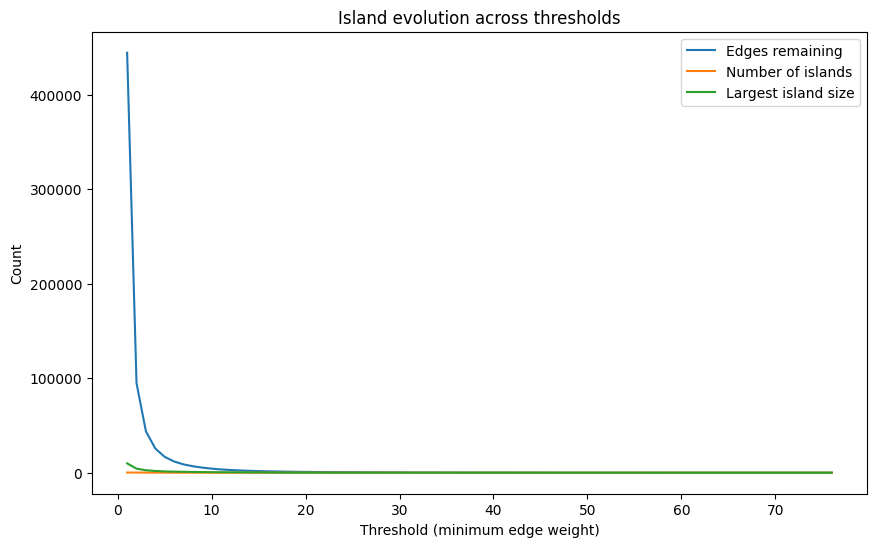

In [381]:
plot_island_evolution(host_graph)

This plot shows the evolution of the host network across different edge-weight thresholds using the Island method. The blue line represents the number of edges remaining, the orange line shows the number of islands (connected components), and the green line indicates the size of the largest island.

At the lower thresholds, the number of edges is very high, meaning that most connections are included. As the threshold increases, weaker edges are removed, and the number of edges drops sharply around the early range (below threshold 10). After this point, the curve flattens, indicating that only strong relationships remain and additional threshold increases no longer remove many connections.

The orange and green lines remain almost flat, showing that the number of islands and the largest island size change very little across thresholds. This suggests that the host network is highly cohesive, with a strong core of hosts that stay connected even as weaker links are removed. The stability of both lines indicates that weak edges play a limited structural role, and the overall connectivity is maintained by a small number of strong, consistent relationships among the host species.

In [382]:
host_graph_10, comps10 = get_island_graph_components(host_graph, threshold=10, remove_unconnected=True)
host_graph_10_comp = comps10[0]

host_graph_5, comps5 = get_island_graph_components(host_graph, threshold=5, remove_unconnected=True)
host_graph_5_comp = comps5[0]

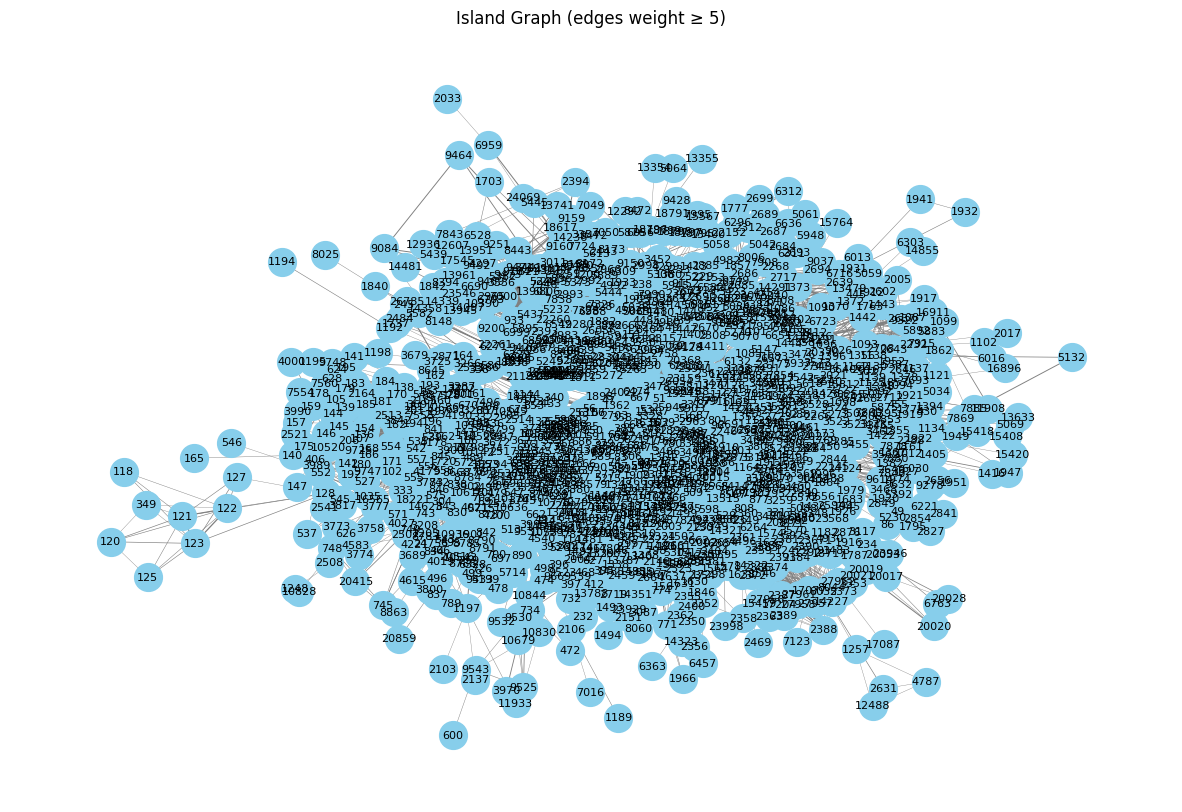

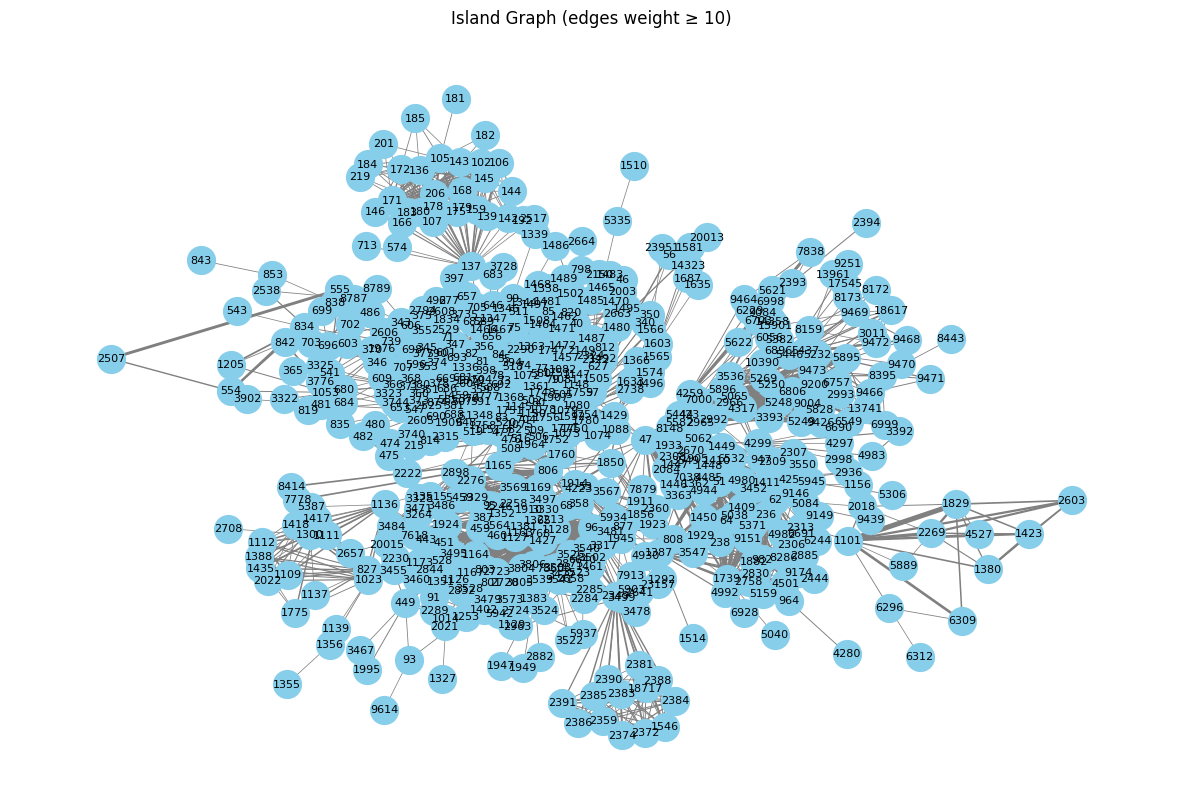

In [383]:


plot_island_graph(comps5[0],5)
plot_island_graph(comps10[0],10)

When comparing the two island graphs, the network at a threshold of 5 shows a large, dense core where most host species remain connected, indicating that many medium-strength interactions still hold the network together. At a higher threshold of 10, the network becomes more fragmented, breaking into several smaller clusters of tightly connected hosts. This shift suggests that while the overall host network is cohesive, only a few strong relationships form stable, well-defined groups once weaker connections are removed.

#### Island Metrics and Centrality Metrics

Host Island ≥5 Metrics 
 
 
 
 
 Metric Name 
 Result 
 
 
 
 
 Average Clustering 
 0.666582 
 
 
 Weighted Average Clustering 
 0.074516 
 
 
 Density 
 0.017051 
 
 
 

 
 
 Degree Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 47 
 0.174511 
 0.740581 
 
 
 1 
 519 
 0.160029 
 0.679122 
 
 
 2 
 398 
 0.147719 
 0.626882 
 
 
 3 
 73 
 0.145547 
 0.617663 
 
 
 4 
 80 
 0.137581 
 0.583861 
 
 
 5 
 356 
 0.137581 
 0.583861 
 
 
 6 
 504 
 0.135409 
 0.574642 
 
 
 7 
 379 
 0.132513 
 0.562350 
 
 
 8 
 74 
 0.130340 
 0.553131 
 
 
 9 
 692 
 0.128892 
 0.546985 
 
 
 
 
 
 Betweenness Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 47 
 0.352586 
 14.080694 
 
 
 1 
 806 
 0.075425 
 3.012143 
 
 
 2 
 1080 
 0.069951 
 2.793529 
 
 
 3 
 2276 
 0.069351 
 2.769572 
 
 
 4 
 96 
 0.067580 
 2.698820 
 
 
 5 
 137 
 0.063373 
 2.530834 
 
 
 6 
 1914 
 0.046025 
 1.838013 
 
 
 7 
 739 
 0.045417 
 1.813760 
 
 
 8 
 519 
 0.044230 
 1.766337 
 
 
 9 
 62 
 0.035779 
 1.428836 
 
 
 
 
 
 Eigenvector Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 73 
 0.143559 
 0.946948 
 
 
 1 
 398 
 0.141554 
 0.933727 
 
 
 2 
 519 
 0.141505 
 0.933398 
 
 
 3 
 692 
 0.137043 
 0.903972 
 
 
 4 
 504 
 0.134189 
 0.885144 
 
 
 5 
 379 
 0.132338 
 0.872936 
 
 
 6 
 356 
 0.127402 
 0.840374 
 
 
 7 
 74 
 0.125703 
 0.829165 
 
 
 8 
 378 
 0.119983 
 0.791439 
 
 
 9 
 82 
 0.117211 
 0.773153

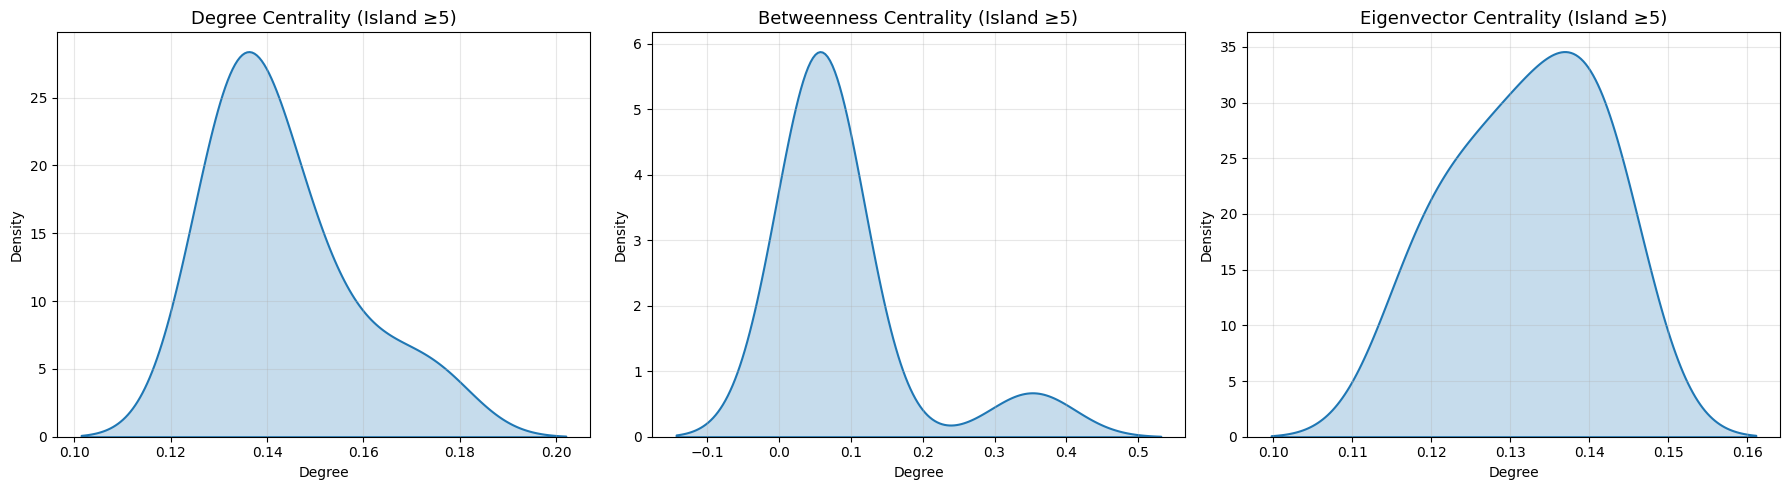

In [443]:
# Analyze Host Island ≥5
host_island_5_results = analyze_island_metrics(
    host_graph_5_comp,
    top_n=10,
    graph_label="Host Island ≥5"
)

# Plot the density plots for Island ≥5
plot_island_density_row(
    host_island_5_results,
    ["degree_centrality", "betweenness_centrality", "eigenvector_centrality"],
    [
        "Degree Centrality (Island ≥5)",
        "Betweenness Centrality (Island ≥5)",
        "Eigenvector Centrality (Island ≥5)"
    ]
)


At a threshold of 5, the network shows a moderately cohesive structure with an average clustering coefficient of 0.67 and a density of 0.017, meaning that hosts are well connected but the network is not overly dense. Node 47 stands out as the most central in both degree and betweenness, suggesting it plays an important role in linking different parts of the network. Nodes 519, 398, and 73 also rank high in degree and eigenvector centrality, showing that they are not only well connected but also linked to other influential nodes. Overall, several hosts share high centrality values, indicating that influence in the network is distributed among multiple key species rather than dominated by one.

At a threshold of 10, the network becomes smaller and more compact but stays cohesive. The average clustering coefficient slightly decreases to 0.66, while density increases to 0.023, showing that the remaining connections are concentrated within tightly linked groups. Node 47 continues to act as the main bridge, with the highest betweenness centrality, while nodes 398, 80, and 519 remain highly ranked in both degree and eigenvector centrality. These nodes continue to anchor the structure of the network even as weaker links are removed, forming stable cores that keep it connected.

Comparing both thresholds shows how the network evolves as weaker connections are filtered out. At 5, the structure is broad and well connected, supported by many medium-strength links. By 10, only the strongest ties remain, forming smaller but denser clusters. Despite this shift, nodes 47, 398, 519, and 73 consistently appear as central, showing that they make up the stable backbone of the host network. This suggests that while weaker connections help maintain overall cohesion, a small group of strongly connected hosts holds the network together.

Host Island ≥10 Metrics 
 
 
 
 
 Metric Name 
 Result 
 
 
 
 
 Average Clustering 
 0.659819 
 
 
 Weighted Average Clustering 
 0.139759 
 
 
 Density 
 0.023249 
 
 
 

 
 
 Degree Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 80 
 0.164129 
 1.192525 
 
 
 1 
 398 
 0.148900 
 1.081879 
 
 
 2 
 73 
 0.143824 
 1.044996 
 
 
 3 
 55 
 0.143824 
 1.044996 
 
 
 4 
 519 
 0.140440 
 1.020408 
 
 
 5 
 520 
 0.135364 
 0.983526 
 
 
 6 
 692 
 0.130288 
 0.946644 
 
 
 7 
 356 
 0.130288 
 0.946644 
 
 
 8 
 379 
 0.128596 
 0.934350 
 
 
 9 
 394 
 0.120135 
 0.872879 
 
 
 
 
 
 Betweenness Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 47 
 0.410507 
 13.243407 
 
 
 1 
 1080 
 0.195843 
 6.318100 
 
 
 2 
 806 
 0.177040 
 5.711497 
 
 
 3 
 356 
 0.169174 
 5.457727 
 
 
 4 
 96 
 0.131427 
 4.239966 
 
 
 5 
 137 
 0.103361 
 3.334545 
 
 
 6 
 519 
 0.095288 
 3.074104 
 
 
 7 
 2276 
 0.092768 
 2.992787 
 
 
 8 
 57 
 0.091379 
 2.947991 
 
 
 9 
 80 
 0.070861 
 2.286053 
 
 
 
 
 
 Eigenvector Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 398 
 0.191043 
 1.828779 
 
 
 1 
 80 
 0.187484 
 1.794707 
 
 
 2 
 519 
 0.183341 
 1.755053 
 
 
 3 
 73 
 0.180357 
 1.726486 
 
 
 4 
 55 
 0.179490 
 1.718193 
 
 
 5 
 520 
 0.175941 
 1.684212 
 
 
 6 
 504 
 0.170730 
 1.634332 
 
 
 7 
 692 
 0.170423 
 1.631392 
 
 
 8 
 394 
 0.161725 
 1.548132 
 
 
 9 
 518 
 0.152668 
 1.461429

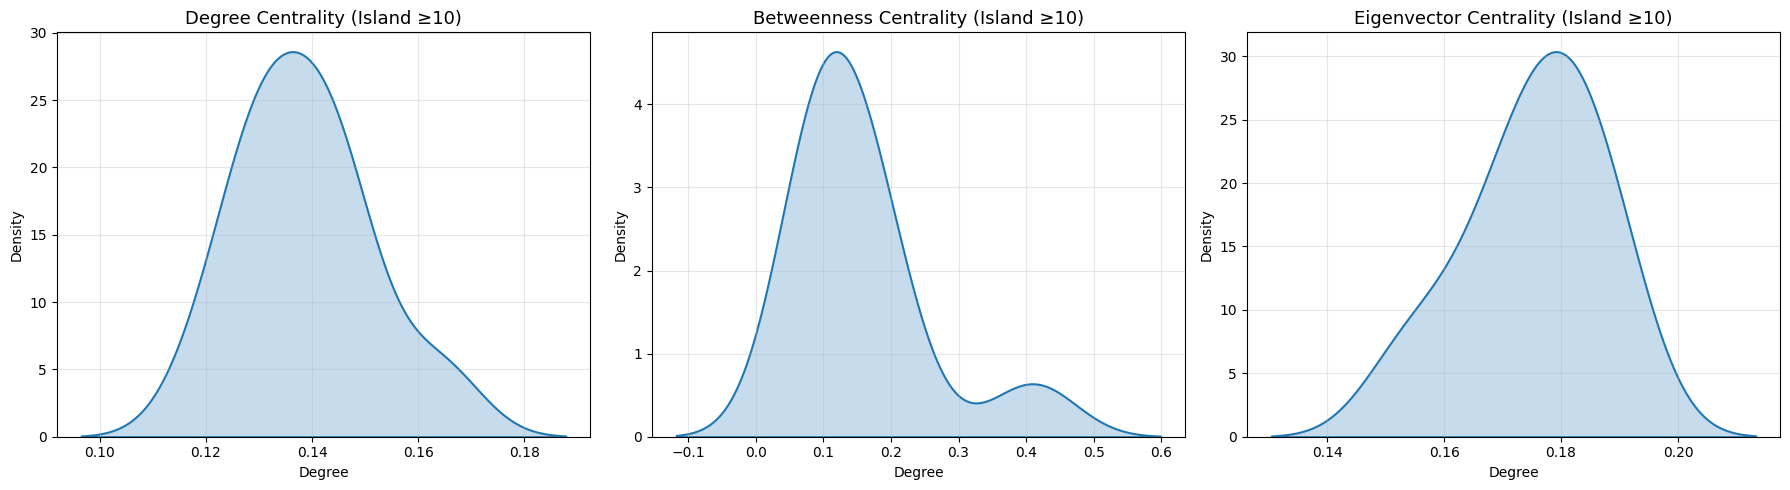

In [444]:

# Analyze Host Island ≥10
host_island_10_results = analyze_island_metrics(
    host_graph_10_comp,
    top_n=10,
    graph_label="Host Island ≥10"
)

# Plot the density plots for Island ≥10
plot_island_density_row(
    host_island_10_results,
    ["degree_centrality", "betweenness_centrality", "eigenvector_centrality"],
    [
        "Degree Centrality (Island ≥10)",
        "Betweenness Centrality (Island ≥10)",
        "Eigenvector Centrality (Island ≥10)"
    ]
)


#### Circulation Points and Bridges

In [385]:
connectivity_10 = analyze_connectivity(host_graph_10_comp, graph_label="Island ≥10")
connectivity_5 = analyze_connectivity(host_graph_5_comp, graph_label="Island ≥5")

display_side_by_side([connectivity_5,connectivity_10],["Island ≥5","Island ≥10"])

Metric,Count,Details
Articulation Points,104,"[731, 208, 1922, 1383, 20030, 445, 1487, 2003, 1182, 8035, 2373, 2232, 9026, 1367, 1395, 1388, 2708, 5017, 1136, 2875, 23941, 3568, 93, 1931, 6651, 449, 1023, 2649, 7913, 1373, 2018, 2307, 2306, 5306, 5159, 1371, 6959, 1200, 6450, 22261, 5437, 18796, 5934, 3317, 1914, 1101, 1411, 947, 238, 236, 1127, 1638, 1898, 1603, 1846, 1592, 1566, 2538, 140, 3672, 842, 834, 4583, 555, 128, 552, 1053, 853, 838, 631, 626, 739, 1080, 96, 7555, 603, 597, 806, 507, 3745, 486, 9543, 9531, 471, 398, 4178, 20516, 375, 374, 368, 336, 4188, 106, 351, 1192, 245, 1197, 1186, 2106, 4540, 47, 1844, 57, 5]"
Bridges,151,"[(5, 498), (57, 164), (351, 3702), (368, 3287), (374, 3697), (375, 20516), (398, 1144), (398, 1827), (471, 3970), (486, 496), (486, 4019), (507, 9539), (603, 7555), (739, 4179), (739, 18221), (739, 3689), (1080, 5589), (1080, 1567), (1080, 6283), (1080, 15279), (3745, 499), (3745, 4199), (731, 232), (731, 732), (731, 966), (806, 3313), (806, 3483), (1487, 8060), (2003, 2151), (47, 8238), (47, 1844), (47, 19443), (47, 5414), (47, 5690), (47, 22541), (47, 6273), (47, 14489), (47, 14632), (47, 6905), (47, 24087), (47, 24129), (47, 24166), (47, 24186), (47, 24234), (47, 8133), (96, 5488), (96, 1979), (236, 17826), (236, 24191), (238, 12292), (238, 8472), (336, 8871), (853, 3679), (853, 3725), (947, 2443), (1127, 3584), (1186, 2484), (1411, 2268), (1411, 5042), (1411, 7908), (1411, 8006), (1566, 23998), (1592, 14351), (1592, 23929), (1603, 1683), (1603, 1846), (1844, 1840), (1898, 6328), (1914, 6802), (1914, 3348), (1914, 1916), (2018, 7724), (2018, 9159), (2649, 5576), (2649, 6034), (3317, 20370), (5159, 9184), (5437, 5439), (22261, 26785), (5934, 7915), (6450, 14339), (23941, 14291), (7913, 25229), (49, 449), (449, 5230), (449, 2854), (2875, 2876), (1101, 9037), (1136, 1853), (5306, 9428), (1371, 5061), (2307, 7995), (93, 86), (4188, 10543), (2538, 24755), (1053, 4221), (3672, 571), (4540, 2106), (6651, 1931), (1023, 1012), (1023, 1161), (1023, 2288), (1023, 1405), (1383, 6030), (1383, 1951), (106, 16565), (140, 165), (208, 3353), (2306, 5948), (245, 8025), (1192, 1194), (838, 3758), (552, 546), (597, 3800), (631, 628), (4178, 10520), (20516, 20859), (842, 789), (9531, 9532), (445, 14855), (445, 6303), (2232, 2017), (555, 2541), (834, 8863), (4583, 1248), (626, 10828), (600, 9543), (7555, 7554), (7555, 7560), (20030, 20021), (1388, 1795), (1395, 5069), (2708, 1102), (2708, 6016), (1367, 1416), (9026, 16911), (1638, 2469), (1373, 15764), (3568, 6763), (1182, 7123), (1197, 2103), (1197, 2137), (1197, 11933), (1189, 2106), (2106, 7016), (6959, 2033), (5017, 11908), (1922, 15420), (2373, 17087), (1846, 6363), (1846, 6457)]"
Metric,Count,Details
Articulation Points,62,"[508, 3744, 374, 481, 834, 853, 838, 739, 366, 345, 1566, 1603, 1760, 3806, 1924, 460, 1014, 93, 449, 1300, 1023, 1356, 1383, 5934, 20015, 387, 2349, 806, 96, 6296, 2393, 423, 8395, 5437, 5896, 7000, 3536, 425, 1739, 1411, 1387, 238, 964, 4299, 62, 4259, 47, 1080, 99, 394, 5335, 1465, 1457, 77, 547, 74, 379, 57, 105, 137, 356, 820]"
Bridges,85,"[(356, 137), (356, 683), (356, 3728), (379, 480), (547, 835), (74, 1468), (77, 1502), (820, 2664), (1457, 1470), (1457, 1483), (1457, 1495), (1457, 2003), (47, 4259), (47, 5444), (47, 5582), (47, 8148), (57, 350), (62, 9439), (96, 2641), (96, 3478), (238, 6928), (423, 2393), (425, 5306), (806, 4223), (806, 3481), (1080, 2738), (1387, 1514), (1411, 1156), (1739, 5040), (3536, 5621), (3536, 6998), (4259, 6229), (4299, 2998), (4299, 4297), (4299, 6690), (5896, 6703), (5934, 23157), (7000, 5622), (394, 397), (508, 2222), (374, 486), (99, 1339), (1465, 5335), (93, 9614), (449, 3467), (449, 1995), (387, 20015), (460, 1402), (460, 2832), (460, 5942), (1383, 1947), (1383, 1949), (3806, 2882), (1924, 2657), (105, 181), (137, 192), (137, 2517), (137, 574), (137, 713), (964, 4280), (345, 8789), (366, 3325), (3744, 819), (739, 838), (20015, 20013), (2393, 2394), (1014, 1327), (1023, 1139), (1023, 1356), (48

At a threshold of 5, the host network is highly connected, with 104 articulation points and 151 bridges. This means that many nodes and edges are important for keeping the network together. The large number of articulation points shows that several hosts act as connectors between different parts of the network, while the many bridges indicate that some relationships serve as the only link between otherwise separate groups. Overall, the network at this level depends on a wide web of weak and medium-strength connections to stay cohesive.

When the threshold increases to 10, the number of articulation points drops to 62 and bridges to 85, showing that the network becomes more stable and less dependent on weaker links. Most of the remaining connections are strong and reliable, forming a smaller but sturdier structure. This change suggests that as weaker ties are removed, the network reorganizes around a few strong cores where closely related hosts remain tightly connected.

#### Core Number

The core number analysis provides a structural view of how densely connected groups of hosts are organized within the network.

In [386]:
core_summary_top10 = summarize_core_numbers(host_graph_10_comp)
core_summary_top5 = summarize_core_numbers(host_graph_5_comp)

display_side_by_side([core_summary_top5.head(5).style.hide(axis="index"),core_summary_top10.head(5).style.hide(axis="index")],["Island ≥5 (Top 5 Cores)","Island ≥10 (Top 5 Cores)"])

Core_Number,Node_Count,Nodes
51,62,"[5, 71, 73, 74, 81, 82, 137, 343, 345, 346, 347, 351, 353, 355, 356, 359, 360, 366, 368, 370, 371, 373, 374, 377, 378, 379, 380, 398, 504, 507, 519, 541, 547, 588, 590, 591, 596, 601, 609, 653, 656, 657, 676, 681, 684, 686, 690, 692, 693, 698, 707, 739, 874, 1336, 1879, 1976, 2525, 2529, 2604, 2605, 3323, 3744]"
50,4,"[589, 606, 688, 819]"
49,1,[655]
48,1,[680]
47,5,"[83, 705, 3735, 8789, 8841]"
Core_Number,Node_Count,Nodes
23,30,"[55, 80, 394, 398, 502, 504, 505, 506, 508, 509, 516, 518, 519, 520, 582, 704, 1072, 1075, 1078, 1080, 1145, 1148, 1151, 1361, 1363, 1747, 1748, 1751, 1753, 1756]"
22,7,"[73, 379, 692, 1079, 1082, 1147, 1907]"
21,15,"[74, 79, 81, 82, 83, 84, 356, 378, 477, 580, 588, 648, 693, 1336, 1879]"
20,2,"[681, 1150]"


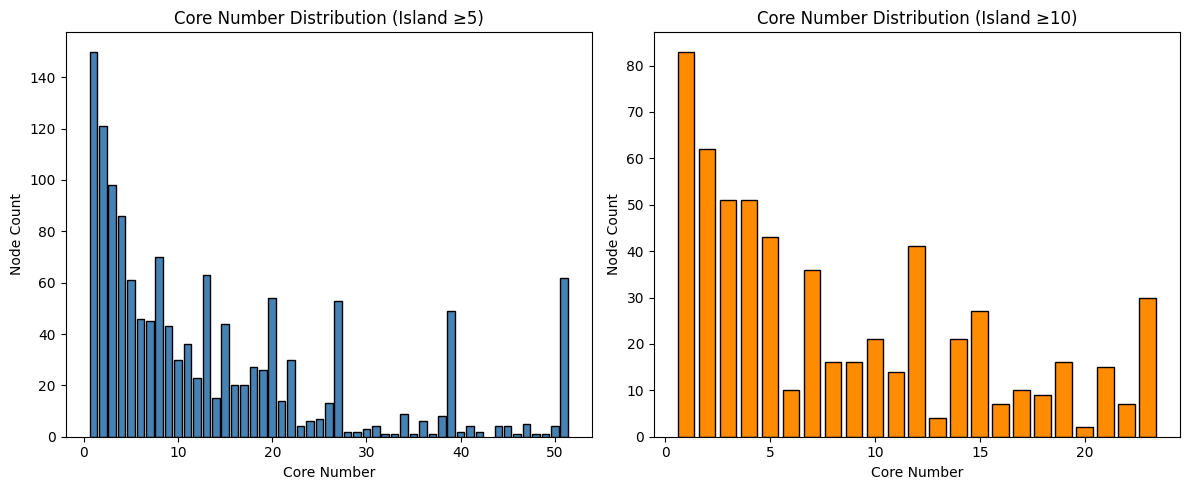

In [387]:

plt.figure(figsize=(12, 5))

# Histogram for Island ≥5
plt.subplot(1, 2, 1)
plt.bar(core_summary_top5["Core_Number"], core_summary_top5["Node_Count"],
        color="steelblue", edgecolor="black")
plt.title("Core Number Distribution (Island ≥5)")
plt.xlabel("Core Number")
plt.ylabel("Node Count")

# Histogram for Island ≥10
plt.subplot(1, 2, 2)
plt.bar(core_summary_top10["Core_Number"], core_summary_top10["Node_Count"],
        color="darkorange", edgecolor="black")
plt.title("Core Number Distribution (Island ≥10)")
plt.xlabel("Core Number")
plt.ylabel("Node Count")

plt.tight_layout()
plt.show()


The comparison of the two thresholds shows how the host network becomes more compact as weaker connections are removed. At a threshold of 5, the network has a highly cohesive core with 62 nodes and a core value of 51, reflecting strong overall connectivity. When the threshold increases to 10, both the core value and node count drop, forming a smaller but tightly linked cluster of 30 nodes with a core value of 23. This shift highlights how the network reorganizes around its strongest relationships as weaker ties disappear. The core analysis aligns with earlier results from the island and centrality metrics, confirming that the host network remains cohesive and resilient across thresholds, supported by a stable backbone of highly interconnected species.

#### Findings

Based on the analysis across thresholds, the host network shows a clear pattern of strong internal cohesion supported by a resilient core of key species. At lower thresholds, many hosts are connected through a wide web of weak and moderate ties, forming a large and highly cohesive structure. As weaker connections are removed, the network becomes smaller and more compact, yet it remains well connected through a stable inner group of hosts that share strong and consistent parasite relationships. This suggests that while many hosts contribute to the overall connectivity of the system, a smaller set of central species maintains its structural integrity. In other words, the host network is organized around a dense and stable backbone of highly interconnected species, indicating that these core hosts likely play a central role in sustaining parasite diversity and linking different parts of the ecological system.

### 3.2 Parasites


In [388]:

parasite_graph = bipartite.weighted_projected_graph(GN,set(parasite_nodes))
weights_par = nx.get_edge_attributes(parasite_graph, 'weight')
max_weight_par = max(weights_par.values())

In [389]:
max_weight_par

119

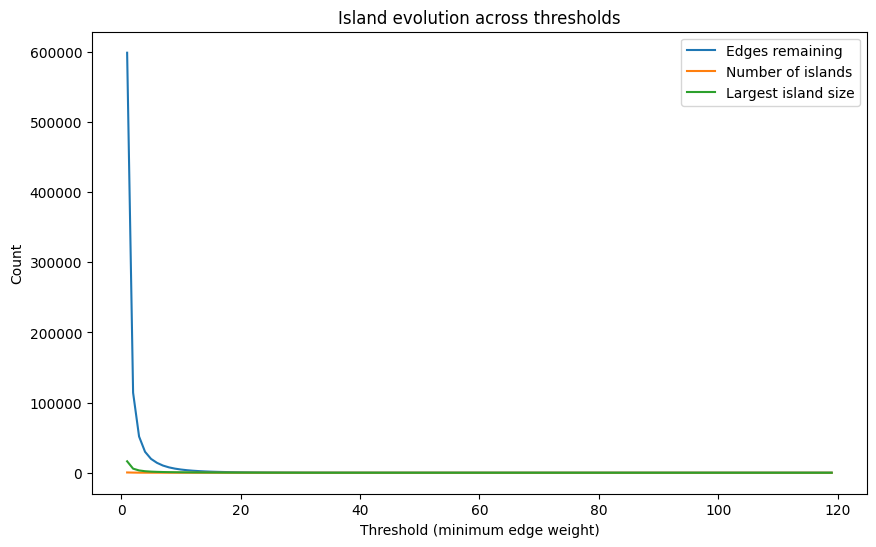

In [390]:
plot_island_evolution(parasite_graph)

This plot shows how the parasite network changes as weak connections are removed. The sharp drop in the blue line at low thresholds means that most connections in the network are weak, and they disappear quickly when the edge weight requirement increases. After about threshold 10, the blue line levels off, showing that only the strongest parasite connections remain.

The orange line, which shows the number of islands, and the green line, which shows the size of the largest island, both stay mostly flat. This means that even after many weak links are gone, the main part of the network stays connected. Overall, the parasite network, like the host network, has a strong and stable core that holds together even when weaker relationships are filtered out.

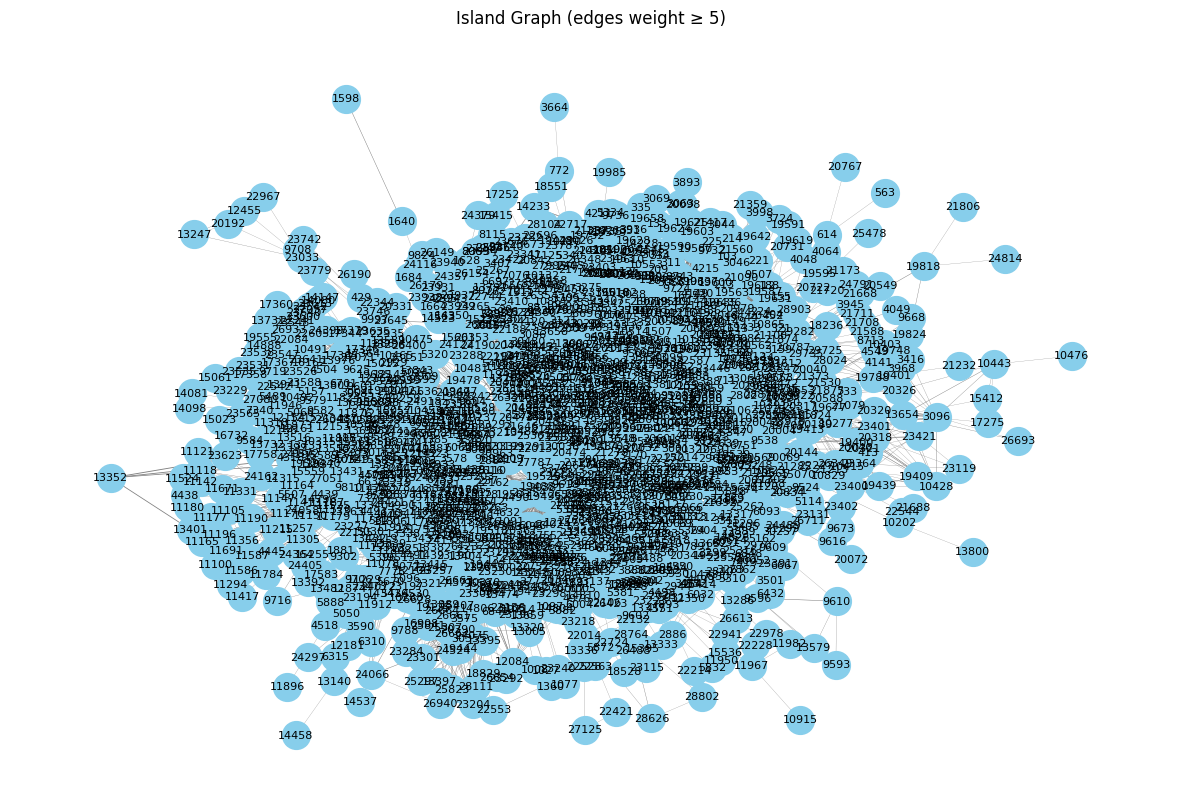

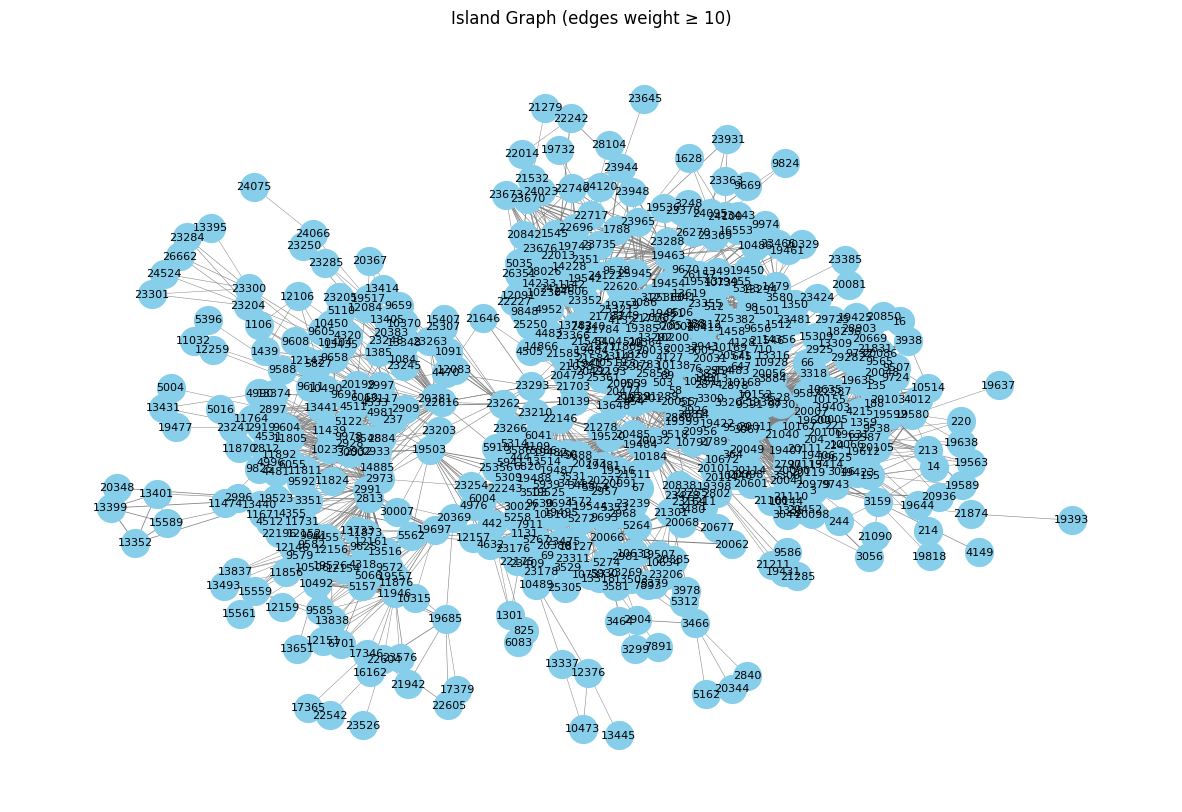

In [415]:
parasite_graph_10, parasite_comps10 = get_island_graph_components(parasite_graph, threshold=10, remove_unconnected=True)
parasite_graph_10_comp = parasite_comps10[0]

parasite_graph_5, parasite_comps5 = get_island_graph_components(parasite_graph, threshold=5, remove_unconnected=True)
parasite_graph_5_comp = parasite_comps5[0]

plot_island_graph(parasite_comps5[0], 5)
plot_island_graph(parasite_comps10[0], 10)


#### Island Metrics and Centrality Metrics

Parasite Island ≥5 Metrics 
 
 
 
 
 Metric Name 
 Result 
 
 
 
 
 Average Clustering 
 0.677275 
 
 
 Weighted Average Clustering 
 0.045666 
 
 
 Density 
 0.016109 
 
 
 

 
 
 Degree Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 9509 
 0.156611 
 0.623594 
 
 
 1 
 9528 
 0.150193 
 0.598037 
 
 
 2 
 9559 
 0.144416 
 0.575036 
 
 
 3 
 2982 
 0.139923 
 0.557146 
 
 
 4 
 89 
 0.138639 
 0.552034 
 
 
 5 
 3067 
 0.125802 
 0.500920 
 
 
 6 
 20271 
 0.120668 
 0.480474 
 
 
 7 
 20032 
 0.118742 
 0.472807 
 
 
 8 
 9591 
 0.118100 
 0.470251 
 
 
 9 
 19525 
 0.117458 
 0.467696 
 
 
 
 
 
 Betweenness Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 9509 
 0.087655 
 3.562402 
 
 
 1 
 2813 
 0.067931 
 2.760802 
 
 
 2 
 19525 
 0.067713 
 2.751928 
 
 
 3 
 23262 
 0.063178 
 2.567635 
 
 
 4 
 9528 
 0.060368 
 2.453416 
 
 
 5 
 19684 
 0.054968 
 2.233961 
 
 
 6 
 2982 
 0.053200 
 2.162099 
 
 
 7 
 2880 
 0.050416 
 2.048958 
 
 
 8 
 19484 
 0.050325 
 2.045272 
 
 
 9 
 20271 
 0.048805 
 1.983485 
 
 
 
 
 
 Eigenvector Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 9559 
 0.149447 
 0.897097 
 
 
 1 
 89 
 0.148822 
 0.893343 
 
 
 2 
 454 
 0.136958 
 0.822130 
 
 
 3 
 2982 
 0.136089 
 0.816914 
 
 
 4 
 3005 
 0.134438 
 0.806998 
 
 
 5 
 20003 
 0.127280 
 0.764032 
 
 
 6 
 517 
 0.126335 
 0.758363 
 
 
 7 
 10151 
 0.124822 
 0.749280 
 
 
 8 
 503 
 0.123364 
 0.740525 
 
 
 9 
 383 
 0.120569 
 0.723745

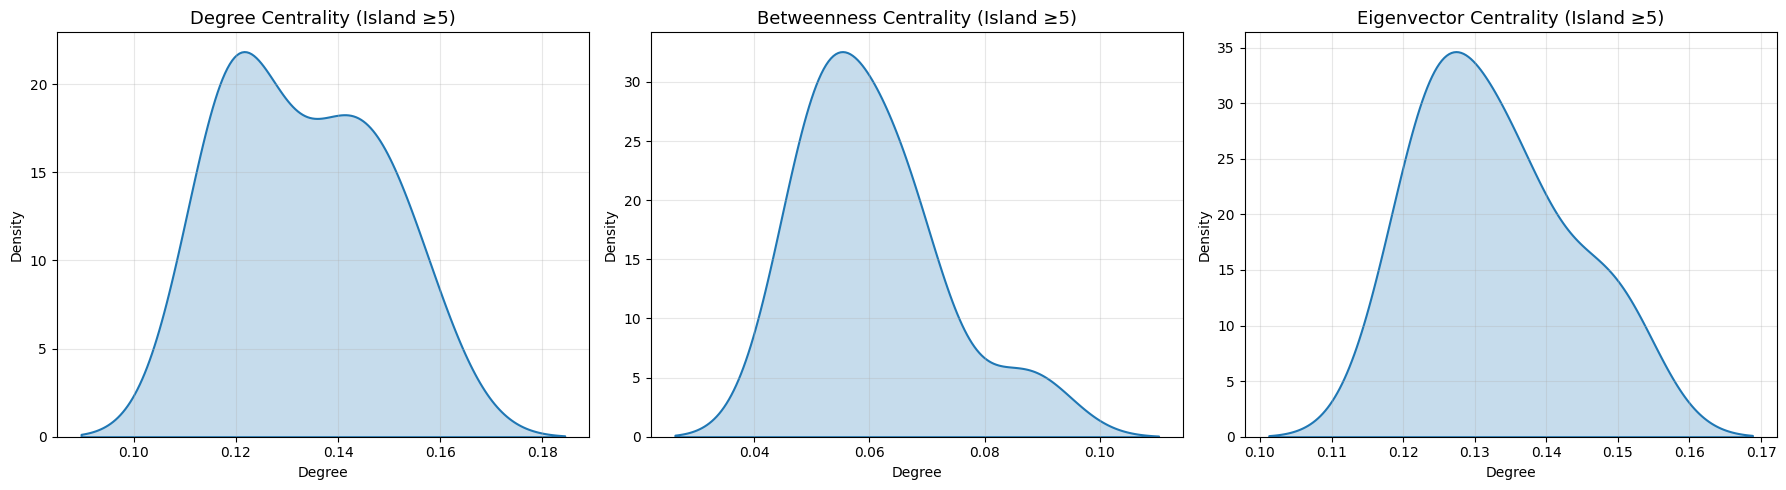

In [437]:
parasite_island_5_results = analyze_island_metrics(
    parasite_graph_5_comp,
    top_n=10,
    graph_label="Parasite Island ≥5"
)

plot_island_density_row(
    parasite_island_5_results,
    ["degree_centrality", "betweenness_centrality", "eigenvector_centrality"],
    [
        "Degree Centrality (Island ≥5)",
        "Betweenness Centrality (Island ≥5)",
        "Eigenvector Centrality (Island ≥5)"
    ])



The Parasite Island ≥5 network demonstrates a balanced and resilient organization. The moderate clustering coefficient (0.677) and low density (0.016) indicate that parasites form small, interconnected groups with limited overall links, while the low weighted clustering (0.0457) shows that most of these connections are weak. Centrality metrics reinforce this structure: degree (0.47–0.62%) and betweenness (1.98–3.56%) values suggest that connectivity and information flow are shared among several nodes rather than dominated by a few. Eigenvector scores (around 0.14–0.15) further confirm that influence is distributed within a small core group instead of concentrated in one parasite. The density plots visually support these findings, showing smooth, single peaks without heavy tails, which means centrality values cluster around similar ranges and no nodes display extreme importance. Together, the numerical and visual analyses point to a decentralized, cohesive, and stable network, where multiple parasites share comparable structural roles, promoting robustness and reducing reliance on any single species.

Parasite Island ≥10 Metrics 
 
 
 
 
 Metric Name 
 Result 
 
 
 
 
 Average Clustering 
 0.657301 
 
 
 Weighted Average Clustering 
 0.083296 
 
 
 Density 
 0.024662 
 
 
 

 
 
 Degree Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 9559 
 0.196694 
 1.316081 
 
 
 1 
 89 
 0.183471 
 1.227605 
 
 
 2 
 9528 
 0.173554 
 1.161248 
 
 
 3 
 454 
 0.165289 
 1.105950 
 
 
 4 
 9509 
 0.158678 
 1.061712 
 
 
 5 
 3005 
 0.158678 
 1.061712 
 
 
 6 
 9591 
 0.132231 
 0.884760 
 
 
 7 
 383 
 0.130579 
 0.873701 
 
 
 8 
 76 
 0.130579 
 0.873701 
 
 
 9 
 20003 
 0.128926 
 0.862641 
 
 
 
 
 
 Betweenness Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 20032 
 0.139182 
 4.947463 
 
 
 1 
 23293 
 0.132016 
 4.692735 
 
 
 2 
 19484 
 0.104016 
 3.697439 
 
 
 3 
 19525 
 0.103576 
 3.681780 
 
 
 4 
 22616 
 0.102025 
 3.626648 
 
 
 5 
 9559 
 0.096899 
 3.444448 
 
 
 6 
 19684 
 0.094844 
 3.371409 
 
 
 7 
 19697 
 0.093690 
 3.330366 
 
 
 8 
 2909 
 0.088858 
 3.158598 
 
 
 9 
 23262 
 0.085046 
 3.023120 
 
 
 
 
 
 Eigenvector Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 0 
 9559 
 0.210297 
 1.856281 
 
 
 1 
 89 
 0.204349 
 1.803778 
 
 
 2 
 454 
 0.193813 
 1.710781 
 
 
 3 
 3005 
 0.185387 
 1.636404 
 
 
 4 
 10151 
 0.162959 
 1.438430 
 
 
 5 
 20003 
 0.159467 
 1.407608 
 
 
 6 
 503 
 0.158750 
 1.401276 
 
 
 7 
 383 
 0.149172 
 1.316738 
 
 
 8 
 517 
 0.149154 
 1.316575 
 
 
 9 
 21289 
 0.147038 
 1.297900

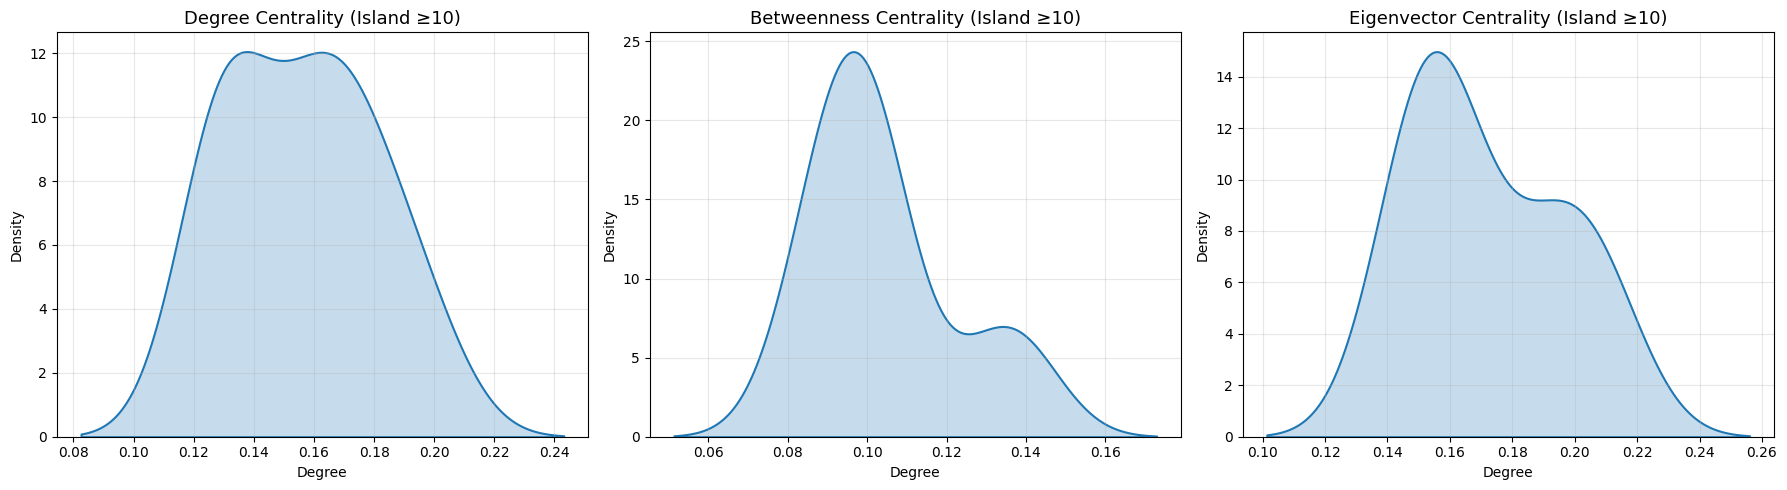

In [440]:

parasite_island_10_results = analyze_island_metrics(
    parasite_graph_10_comp,
    top_n=10,
    graph_label="Parasite Island ≥10"
)

plot_island_density_row(
    parasite_island_10_results,
    ["degree_centrality", "betweenness_centrality", "eigenvector_centrality"],
    [
        "Degree Centrality (Island ≥10)",
        "Betweenness Centrality (Island ≥10)",
        "Eigenvector Centrality (Island ≥10)"
    ])


The Parasite Island ≥10 network appears more connected and structured than the ≥5 island, based on both the table values and the density plots. The density rises to 0.0247, and the average clustering stays high at 0.657, showing that parasites still form close groups with somewhat stronger links, supported by the higher weighted clustering (0.0833). The degree centrality values (1.1–1.3%) are more spread out, meaning that while most parasites have similar connections, a few such as 9559, 89, and 9528 are becoming more central. The betweenness centrality results show a similar trend, with higher variation and top nodes like 20032 and 23293 acting as stronger bridges between groups. The eigenvector centrality scores identify 9559, 89, and 454 as the most influential nodes, forming a small, well-connected core. These findings are supported by the density plots, where the wider and slightly skewed curves suggest that influence and connectivity are starting to concentrate around a few nodes. Overall, the network is becoming more organized and slightly more hierarchical, yet it remains balanced, cohesive, and stable, with multiple parasites still contributing to its overall structure.

#### Circulation Points and Bridges

In [441]:
par_connectivity_10 = analyze_connectivity(parasite_graph_10_comp, graph_label="Parasite Island ≥10")
par_connectivity_5 = analyze_connectivity(parasite_graph_5_comp, graph_label="Parasite Island ≥5")

display_side_by_side([par_connectivity_5, par_connectivity_10], ["Parasite Island ≥5", "Parasite Island ≥10"])


Metric,Count,Details
Articulation Points,120,"[19788, 19684, 20103, 772, 21774, 10739, 19477, 4518, 5396, 11967, 22025, 22014, 22013, 24421, 24466, 23033, 23746, 22935, 13405, 14343, 13348, 19517, 13695, 19685, 23576, 19557, 11946, 9625, 9579, 12142, 10443, 20322, 9618, 19500, 2942, 9674, 19485, 4498, 10473, 13337, 23143, 19531, 20066, 3466, 19544, 5364, 13140, 19697, 9825, 5077, 9978, 19503, 14810, 3000, 1385, 22242, 1640, 1664, 23965, 23944, 10132, 19743, 9848, 10230, 19759, 442, 19525, 22146, 3001, 19495, 3531, 9688, 3503, 20271, 23262, 19488, 10202, 15070, 10184, 237, 22227, 21278, 11147, 11164, 11179, 11150, 11305, 2813, 9997, 10237, 2909, 4470, 3086, 20056, 21213, 20003, 21289, 19483, 3938, 321, 614, 20979, 20722, 3159, 19818, 4215, 9559, 2982, 9518, 19388, 9509, 19814, 19423, 19398, 454, 3067, 89, 20032, 9528, 19484]"
Bridges,197,"[(19484, 23165), (20032, 21058), (20032, 25271), (20032, 21302), (9528, 4131), (9528, 20546), (9528, 28910), (9528, 21824), (9528, 19405), (19398, 733), (19398, 20588), (19398, 21079), (19398, 21530), (19423, 10829), (3067, 311), (3067, 21350), (3067, 9553), (3067, 19435), (3067, 20009), (3067, 20472), (9509, 334), (9509, 10205), (9509, 19814), (9509, 20016), (9509, 20045), (9509, 20816), (9509, 21337), (9509, 22414), (9518, 21796), (19388, 21373), (19388, 20040), (4215, 3893), (20722, 25478), (3159, 4141), (3159, 20549), (3159, 4549), (3159, 8713), (3159, 21588), (3159, 21708), (3159, 21711), (3159, 3945), (3159, 3968), (3159, 4049), (3938, 3936), (89, 21841), (9559, 4495), (454, 26565), (20, 19684), (19684, 8077), (19684, 22957), (19684, 23026), (21289, 15172), (2982, 5960), (2982, 15405), (2982, 19539), (20003, 25262), (20056, 20004), (4470, 23236), (10184, 15070), (10237, 9997), (10739, 21774), (2909, 9595), (2909, 7909), (19483, 5340), (23262, 13661), (23262, 23202), (23262, 23223), (23262, 25269), (23262, 30243), (23262, 26660), (23262, 28244), (19488, 25276), (19495, 23218), (19525, 22230), (19525, 23298), (5364, 6432), (3503, 3501), (3531, 26613), (9688, 21296), (20066, 21299), (20066, 30257), (20066, 24489), (22146, 25316), (20271, 1433), (20271, 14826), (20271, 26614), (20271, 23889), (19544, 22941), (20103, 20046), (19759, 5334), (3086, 27947), (3086, 8069), (23965, 1664), (23965, 26179), (237, 11912), (3000, 15015), (19503, 4377), (19503, 26663), (19697, 13589), (19697, 23151), (1385, 4504), (9825, 23473), (9978, 17583), (321, 24791), (614, 563), (614, 20767), (429, 19477), (442, 1008), (442, 1027), (442, 1360), (23143, 23115), (772, 21774), (772, 3664), (21774, 18551), (1077, 13405), (13405, 23240), (13348, 22563), (19517, 23194), (5396, 4518), (9848, 26349), (12142, 5507), (19743, 28024), (23944, 8115), (23944, 15415), (10132, 17252), (1598, 1640), (1640, 1664), (21278, 6093), (10230, 6667), (2813, 11525), (9579, 15061), (9625, 13731), (11147, 4438), (11147, 11165), (11150, 11586), (11164, 11142), (11179, 11784), (23576, 22241), (23576, 23600), (23576, 26933), (23576, 27057), (11305, 11100), (11305, 11294), (11305, 11417), (19557, 22084), (19685, 14080), (19685, 14147), (19685, 23613), (19685, 23640), (11946, 14081), (11946, 14098), (24466, 24399), (24466, 27071), (3466, 22724), (2942, 3263), (22242, 26190), (22242, 22344), (3001, 5114), (5077, 6310), (9618, 12350), (22013, 22106), (22013, 22132), (13695, 14888), (10443, 10476), (20322, 26711), (20322, 23131), (19788, 21232), (19818, 24814), (19818, 21806), (19485, 15395), (19485, 26488), (24421, 24364), (24421, 24405), (4498, 15536), (13337, 5832), (10473, 22978), (4518, 11896), (13140, 14458), (6315, 14343), (14343, 24297), (19814, 19985), (19531, 20072), (14810, 18528), (19500, 13286), (9708, 9997), (22227, 22544), (15070, 10202), (10202, 13800), (10915, 11967), (11950, 22025), (22025, 22214), (22025, 22228), (23033, 22967), (23033, 23746), (21213, 21688), (23746, 23742), (22935, 23779)]"
Metric,Count,Details
Articulation Points,58,"[3159, 19580, 155, 3466, 5930, 19685, 22604, 19523, 12161, 17346, 11946, 10506, 9604, 9611, 289

The articulation point and bridge results show that the Parasite Island ≥5 network is larger but also more fragile, with 120 articulation points and 197 bridges. This means that many parasites act as links holding different parts of the network together, so removing some of them could break the connections between groups. In comparison, the Parasite Island ≥10 network is smaller but stronger, with only 58 articulation points and 94 bridges. This shows that as weaker connections are removed, the remaining parasites become more tightly connected and the network relies less on individual nodes to stay linked. A few parasites, such as 20032, 9528, and 9509, still play important roles in keeping the network connected, but overall the structure is more stable and harder to disrupt. In simple terms, increasing the threshold makes the network more compact, better connected, and less dependent on specific parasites to hold it together.

#### Core Number

The core number analysis provides a structural view of how densely connected groups of hosts are organized within the network.

In [442]:


par_core_summary_top10 = summarize_core_numbers(parasite_graph_10_comp)
par_core_summary_top5 = summarize_core_numbers(parasite_graph_5_comp)

display_side_by_side(
    [par_core_summary_top5.head(5).style.hide(axis="index"), par_core_summary_top10.head(5).style.hide(axis="index")],
    ["Parasite Island ≥5 (Top 5 Cores)", "Parasite Island ≥10 (Top 5 Cores)"]
)


Core_Number,Node_Count,Nodes
47,61,"[67, 444, 450, 2957, 2968, 3474, 3488, 3503, 3529, 3531, 3572, 3586, 4109, 5258, 5264, 5267, 5272, 5309, 5314, 5353, 5364, 5366, 5870, 5918, 5939, 5941, 5984, 6041, 6042, 6820, 7911, 9630, 9688, 9693, 9694, 10510, 10737, 13498, 13514, 18127, 19481, 19482, 19487, 19488, 19495, 19520, 19525, 20032, 20271, 20273, 21511, 22146, 22243, 23254, 23262, 23269, 23311, 23475, 25305, 25356, 30027]"
46,1,[23176]
44,100,"[58, 72, 76, 89, 98, 383, 388, 454, 503, 510, 517, 645, 647, 710, 725, 2874, 2878, 2880, 2881, 2926, 2943, 2954, 2982, 3005, 3067, 3249, 3300, 3320, 3785, 3884, 4127, 4128, 4132, 5404, 9506, 9509, 9518, 9528, 9559, 9591, 9730, 10138, 10151, 10152, 10168, 10169, 10200, 10519, 10928, 11809, 11820, 11941, 13292, 13782, 14356, 14813, 19385, 19388, 19422, 19455, 19483, 19484, 19684, 20003, 20008, 20011, 20031, 20035, 20037, 20055, 20056, 20364, 20419, 20474, 20492, 20571, 20782, 20783, 21038, 21039, 21040, 21289, 21477, 21540, 21546, 21584, 21585, 21716, 21783, 21784, 22193, 23141, 23201, 23293, 24340, 25321, 25360, 25361, 25362, 25859]"
43,3,"[20066, 20091, 25250]"
42,5,"[54, 1458, 1501, 3580, 13316]"
Core_Number,Node_Count,Nodes
27,29,"[89, 454, 503, 517, 2982, 3005, 3249, 3785, 4132, 9506, 9559, 10151, 10200, 11809, 19385, 20003, 20035, 20419, 20474, 21039, 21289, 21585, 21716, 21783, 21784, 23201, 24340, 25321, 25360]"
26,6,"[13292, 20364, 20783, 21540, 21584, 22193]"
25,1,[25362]
23,30,"[58, 72, 76, 383, 2874, 2878, 2880, 2881, 2943, 2954, 3067, 3300, 3320, 3884, 9509, 9528, 9591, 9730, 10138, 10152, 10168, 10169, 19388, 19483, 19484, 19684, 20011, 20031, 20056, 20571]"


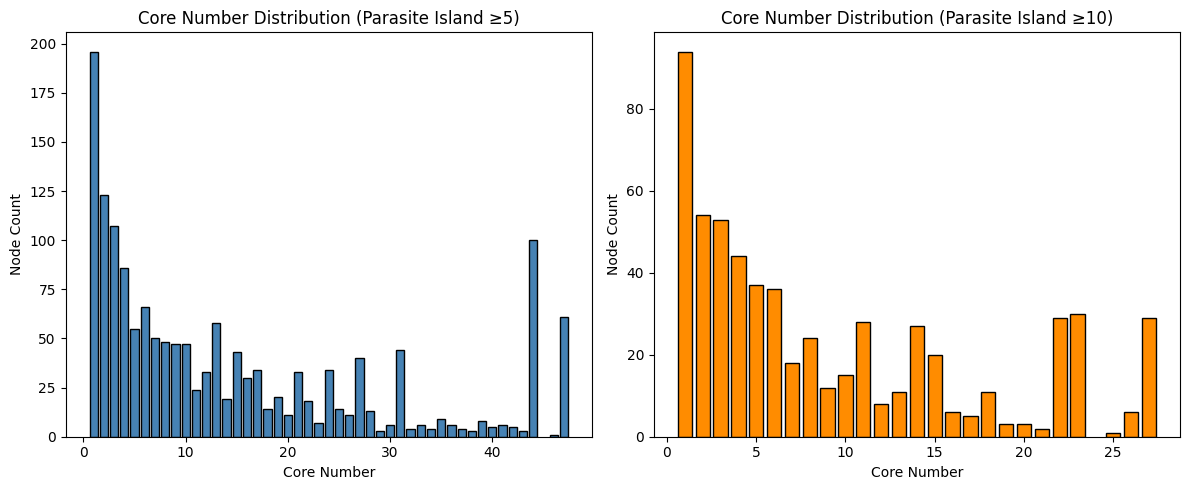

In [369]:
plt.figure(figsize=(12, 5))

# Histogram for Parasite Island ≥5
plt.subplot(1, 2, 1)
plt.bar(par_core_summary_top5["Core_Number"], par_core_summary_top5["Node_Count"],
        color="steelblue", edgecolor="black")
plt.title("Core Number Distribution (Parasite Island ≥5)")
plt.xlabel("Core Number")
plt.ylabel("Node Count")

# Histogram for Parasite Island ≥10
plt.subplot(1, 2, 2)
plt.bar(par_core_summary_top10["Core_Number"], par_core_summary_top10["Node_Count"],
        color="darkorange", edgecolor="black")
plt.title("Core Number Distribution (Parasite Island ≥10)")
plt.xlabel("Core Number")
plt.ylabel("Node Count")

plt.tight_layout()
plt.show()


The core number distributions confirm the earlier findings about the network’s structure. In the Parasite Island ≥5 network, most nodes belong to low cores, with only a few forming tightly connected inner groups, which matches the earlier observation of a broad but balanced structure with many moderately linked parasites. When the threshold increases to ≥10, the distribution becomes steeper and narrower, showing fewer high-core nodes and a smaller but stronger core. This supports what we already saw from the centrality and clustering results: as weaker links are removed, the parasite network becomes more compact, cohesive, and centered around its most strongly connected members.

## Conclusion

Pending
